# Ellipsoid Lightcurves

This notebook is used for viewing the light curves of stars that have crossed the SETI Ellipsoid during Gaia's observation run.

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, QTable, vstack
import os

from astroquery.gaia import Gaia

import ellipsoid

from astropy.timeseries import LombScargle, TimeSeries
import random

### Read in the desired file and set global parameters
If using the ```ellipsoid.py``` script to download Gaia data, the file names are:

```GCNS_var``` -- variable stars in GCNS

```Gaia_var``` -- variable stars in Gaia DR3

```GCNS``` -- stars in GCNS

```Gaia``` -- stars in Gaia DR3

The tolerance is in lightyears, and the default start time is the time of the first Gaia alert

In [10]:
file_name = 'GCNS_var'
c1, stars = ellipsoid.readFile(file_name)
tol = 0.1
start = 2014.569312182902

The default event (i.e. the second focal point of the SETI Ellipsoid) is SN 1987A by default, and its parameters are set below

In [11]:
#Properties of SN1987A
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err = 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

### Get table of crossing stars

```c1_x``` contains astropy SkyCoord objects of each star that has crossed (within some tolerance) the ellipsoid since the start time

```stars_x``` is a table with all the relevant information for each of the stars

In [4]:
c1_x, stars_x = ellipsoid.crossEllipsoid(c0, t0, c1, stars, tol, start)
print(f'{len(stars_x)} stars have crossed the ellipsoid since {start}')

498 stars have crossed the ellipsoid since 2014.569312182902


### Login to Gaia archive

Creating and logging into a Gaia archive account allows for larger data downloads

You can register here:
https://www.cosmos.esa.int/web/gaia-users/register

In [5]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: anilipou
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


### Split the desired stars into chunks of =< 5000 (if needed)

Datalink, the protocol Gaia uses for ancillary data such as epoch photometry and spectra, can only retrieve data for up to 5000 sources at a time. This threshold is overcome by splitting the input into chunks of size =< 5000 sources.

In [12]:
def chunks(lst, n):
    ""
    "Split an input list into multiple chunks of size =< n"
    ""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [13]:
dl_threshold = 5000               # DataLink server threshold. It is not possible to download products for more than 5000 sources in one single call.
ids          = stars_x['id']
ids_chunks   = list(chunks(ids, dl_threshold))
datalink_all = []


print(f'* Input list contains {len(ids)} source_IDs')
print(f'* This list is split into {len(ids_chunks)} chunks of <= {dl_threshold} elements each')

* Input list contains 498 source_IDs
* This list is split into 1 chunks of <= 5000 elements each


### Get lightcurves

When downloading, light curves will all be in one table (merged).

Can also save and read light curve tables once downloaded.

In [14]:
retrieval_type = 'EPOCH_PHOTOMETRY'        # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS' 
data_structure = 'COMBINED'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW' - but as explained above, we strongly recommend to use COMBINED for massive downloads.
data_release   = 'Gaia DR3'   # Options are: 'Gaia DR3' (default), 'Gaia DR2'
dl_key         = f'{retrieval_type}_{data_structure}.xml'


ii = 0
for chunk in ids_chunks:
    ii = ii + 1
    print(f'Downloading Chunk #{ii}; N_files = {len(chunk)}')
    datalink  = Gaia.load_data(ids=chunk, data_release = data_release, retrieval_type=retrieval_type, format = 'votable', data_structure = data_structure)
    datalink_all.append(datalink)

In [15]:
temp = [inp[dl_key][0].to_table() for inp in datalink_all]
merged = vstack(temp)

Save downloaded table

In [24]:
merged_sf = '../GCNS_var_lc.xml'

if os.path.exists(merged_sf):
    os.remove(merged_sf)    
QTable(merged).write(merged_sf, format='votable')

Read saved table

In [27]:
lc_merged = QTable.read(merged_sf, format='votable')

### Make dictionaries for each band

Each source is observed in three bands by Gaia (G, RP, BP), so here we create a dictionary for each band, with the keys equal to the source IDs and the values equal to the light curve table for that source and band

In [31]:
glcDict = {}
bplcDict = {}
rplcDict = {}

In [32]:
for sid in ids:
    glc, bplc, rplc = ellipsoid.getLC(lc_merged, sid, 'G'), ellipsoid.getLC(lc_merged, sid, 'BP'), ellipsoid.getLC(lc_merged, sid, 'RP')
    glcDict[str(sid)], bplcDict[str(sid)], rplcDict[str(sid)] = glc, bplc, rplc

### Pick random light curve(s) and plot

Here, one or many random source IDs are selected, and their light curves are plotted, as well as a vertical line indicating the ellipsoid crossing time.

In [39]:
lcChoice = random.choice(list(glcDict.keys()))

In [42]:
lcChoices = random.choices(list(glcDict.keys()), k=25)

The Gaia archive is again queried to get the Gaia variable classification

In [49]:
lcClass = ellipsoid.varClass(lcChoice)
print(f'Source {lcChoice} has variable classification {lcClass[0]}')

INFO: Query finished. [astroquery.utils.tap.core]
Source 5455707157211784832 has variable classification SOLAR_LIKE


In [50]:
lcClasses = ellipsoid.varClasses(tuple(lcChoices))
lcClasses

INFO: Query finished. [astroquery.utils.tap.core]


best_class_name,source_id
bytes30,int64
SOLAR_LIKE,2888712338056676096
SOLAR_LIKE,2891437851286574720
SOLAR_LIKE,3177407910705445888
SOLAR_LIKE,4715723354835820288
SOLAR_LIKE,4742122117919400320
SOLAR_LIKE,4744905767826489472
SOLAR_LIKE,4817274321793438720
SOLAR_LIKE,4820548358183645696
SOLAR_LIKE,4889604010599273088


Pick a desired source ID

In [119]:
lcID = 5256442871108474880
id_mask = stars_x['id'] == lcID

Get the ellipsoid crossing time for the selected star, as well as the light curve information

In [115]:
xtime = ellipsoid.xTime(c1_x[id_mask])[0]

In [116]:
lcDict = glcDict # choose g, bp, or rp light curve

lcTimes = Time(lcDict[str(lcID)]['time'].value + 2455197.5, format='jd')
lcFlux = lcDict[str(lcID)]['flux']
lcFerr = lcDict[str(lcID)]['flux_error']
lcMag = lcDict[str(lcID)]['mag']
# time offset described at https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_photometry/ssec_dm_epoch_photometry.html

#### Plot with crossing time

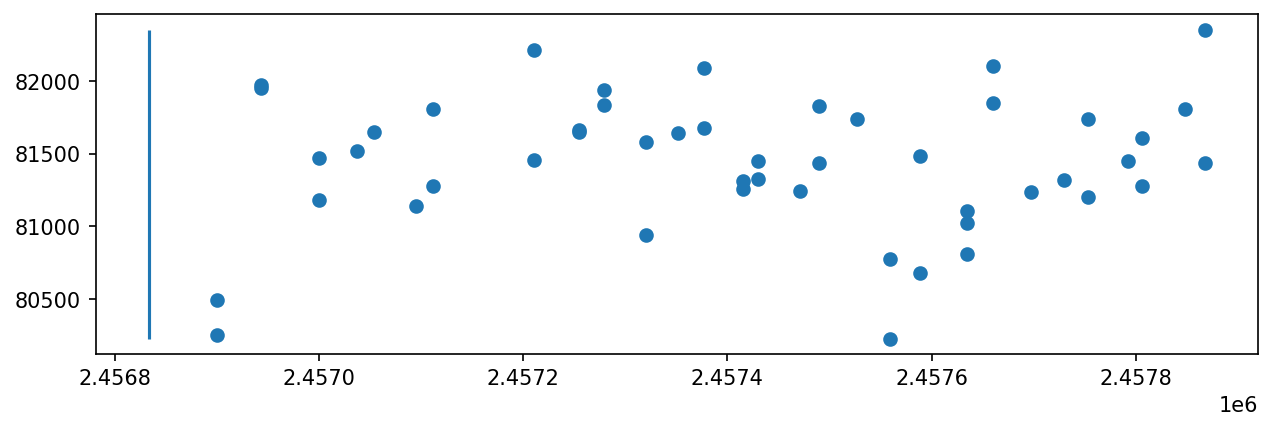

In [117]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value))
plt.scatter(lcTimes.value, lcFlux)

All the above plotting can be done with the ```plotLC``` function:

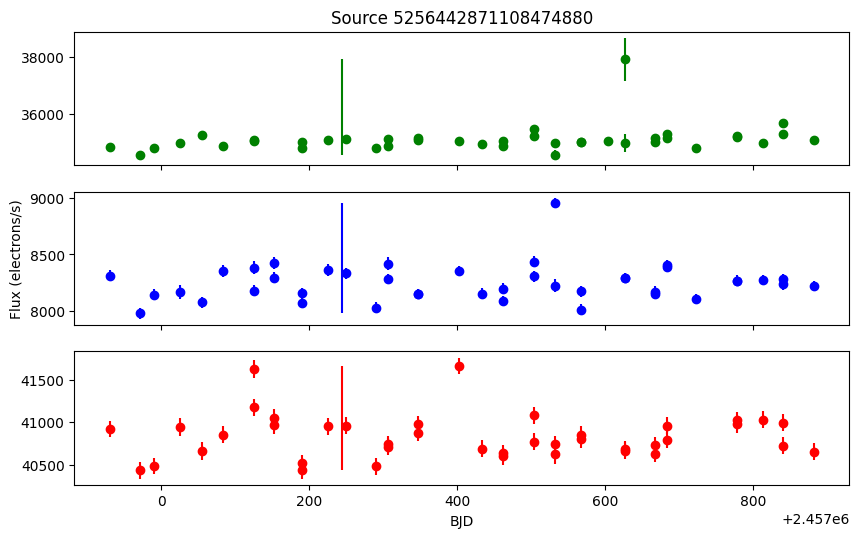

In [120]:
ellipsoid.plotLC(str(lcID), c1_x[id_mask], glcDict, bplcDict, rplcDict, y='flux')